In [136]:
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder
from category_encoders import CountEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import math
warnings.filterwarnings(action='ignore')

random_state = 7

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

ModuleNotFoundError: No module named 'hyperopt'

In [138]:
ori_data = pd.read_csv('./data//tmk_bda_train.csv', index_col=0)

def modify_anomal(row):
    product_name = row.product_name
    if product_name == '[1000개한정미정당 스파이시로제떡볶이 376gx2개':
        product_name = '[1000개한정]미정당 스파이시로제떡볶이 376gx2개'
    product_name = product_name.replace('\xa0', ' ')
    product_name = product_name.replace('  ', ' ')
    return product_name

# 상품명 오기 처리
ori_data['product_name'] = ori_data.apply(modify_anomal, axis=1)

# prime_yn 'Y', 'N'을 1, 0으로 인코딩
encoded_value, encoded_class = pd.factorize(ori_data['prime_yn'])
ori_data['prime_yn'] = encoded_value




## 임시 카테고리 인코딩

In [139]:
product_info = pd.read_csv('./category_name.csv')
ori_data = ori_data.merge(product_info, on='product_name', how='left')

In [140]:
cat_dummy = pd.get_dummies(ori_data["category"])
ori_data = pd.concat([ori_data, cat_dummy], axis=1)


## 전처리

In [141]:
def find_bracket(row):
    product_name = row.product_name
    list_in = ''

    if product_name.find('[') >= 0:
        start = product_name.find('[')
        if product_name.find(']') > start:
            end = product_name.find(']')
            list_in = product_name[start:end+1]

    return list_in

def find_holiday(weekday):
    if weekday == 5 or weekday == 6:
        weekday="주말"
    else:
        weekday="평일"    
    return weekday


# [UPCYCLE], [2023설사원선물신청], [냉동]과 같이 괄호안에 있는 항목 추출
ori_data['list_in'] = ori_data.apply(find_bracket, axis=1)

# week
ori_data['order_date'] = pd.to_datetime(ori_data['order_date'], format='%Y%m%d')
ori_data['week'] = ori_data['order_date'].dt.isocalendar().week + 1
ori_data.loc[ori_data['week'] == 53, 'week'] = 1 # 22년 53주차 -> 23년 1주차 #### 53주차인지 54주차인지 확인 필요
ori_data["week"] = ori_data["week"].astype("int")

# 평/휴일
ori_data["holiday"] = ori_data["order_date"].apply(lambda x: x.weekday())
ori_data["holiday"] = ori_data["holiday"].apply(find_holiday)

ori_data.drop(['order_date', 'category'], axis=1, inplace=True)


# 라벨 인코딩 : prime_yn, gen_age, week, weeks_in_month
le = LabelEncoder()

# train_set["category"] = le.fit_transform(train_set["category"])
ori_data["holiday"] = le.fit_transform(ori_data["holiday"])
ori_data["age_grp"] = le.fit_transform(ori_data["age_grp"])
ori_data["gender"] = le.fit_transform(ori_data["gender"])

In [142]:
# 임직원, 일반 고객 데이터 분리
emp_data = ori_data[ori_data.employee_yn == 'Y']
cus_data = ori_data[ori_data.employee_yn == 'N']

emp_data.reset_index(drop=True, inplace=True)
cus_data.reset_index(drop=True, inplace=True)

emp_data.drop(columns='employee_yn', inplace=True)
cus_data.drop(columns='employee_yn', inplace=True)

# 임직원 데이터 예측

In [143]:
# train, valid set 분리
cus_group_data = cus_data.groupby(by=['scd']).mean()[['prime_yn']]
X = cus_group_data.index.values.reshape(-1, 1)
y = cus_group_data.prime_yn.values

train_list, valid_list, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=random_state)

train_list = train_list.reshape(-1)
valid_list = valid_list.reshape(-1)

train_set = cus_data.iloc[cus_data[cus_data.scd.isin(train_list)].index, :]
valid_set = cus_data.iloc[cus_data[cus_data.scd.isin(valid_list)].index, :]

y_train = train_set.prime_yn
#train_set = train_set.drop('prime_yn', axis=1)
y_valid = valid_set.prime_yn
#valid_set = valid_set.drop('prime_yn', axis=1)

In [83]:
# train, valid set 분리
emp_group_data = emp_data.groupby(by=['scd']).mean()[['prime_yn']]
X = emp_group_data.index.values.reshape(-1, 1)
y = emp_group_data.prime_yn.values

train_list, valid_list, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=random_state)

train_list = train_list.reshape(-1)
valid_list = valid_list.reshape(-1)

train_set = emp_data.iloc[emp_data[emp_data.scd.isin(train_list)].index, :]
valid_set = emp_data.iloc[emp_data[emp_data.scd.isin(valid_list)].index, :]

y_train = train_set.prime_yn
#train_set = train_set.drop('prime_yn', axis=1)
y_valid = valid_set.prime_yn
#valid_set = valid_set.drop('prime_yn', axis=1)

In [84]:
train_set.index

Int64Index([    4,     5,    11,    17,    18,    19,    20,    21,    22,
               23,
            ...
            19795, 19796, 19797, 19798, 19799, 19800, 19801, 19802, 19803,
            19804],
           dtype='int64', length=13861)

## Feature Engineering

### 상품 카테고리 정보 추가 및 정가 추정

#### 상품 카테고리 정보 추가

In [85]:
train = train_set.copy()
valid = valid_set.copy()

#### 정가 추정

In [144]:
# train_set

# 가격 exponential을 취해 기존 가격으로 변환
train_set['price'] = train_set.net_order_amt.apply(lambda x: math.e ** x)

# 상품 한 개당 가격 계산
train_set['qty1_price'] = train_set['price'] / train_set['net_order_qty']

# train_set의 데이터로 정가 추정 후, unit_price로 저장
unit_price = train_set.groupby('product_name')['qty1_price'].max().reset_index().rename(columns={'qty1_price': 'unit_price'})

# 추정된 정가를 컬럼으로 추가하고 할인율 계산
train_set = train_set.merge(unit_price, on='product_name', how='left')
train_set['discount_rate'] = 1 - (train_set['price'] / (train_set['unit_price'] * train_set['net_order_qty']))

# 정가 추정에 사용한 qty1_price 컬럼 삭제
train_set.drop(['qty1_price'], axis=1, inplace=True)


# valid_set

# 가격 변환
valid_set['price'] = valid_set.net_order_amt.apply(lambda x: math.e ** x)

# train에서 추정한 정가로 할인율 계산
valid_set = valid_set.merge(unit_price, on='product_name', how='left')
valid_set['discount_rate'] = 1 - (valid_set['price'] / (valid_set['unit_price'] * valid_set['net_order_qty']))

#### 빈도수 인코딩

In [145]:
# train_set

# 'list_in' 컬럼 빈도수 인코딩
bracket_encoder = CountEncoder(cols="list_in", normalize=True)
train_set["list_frequency"] = bracket_encoder.fit_transform(train_set["list_in"])

train_set.drop(['scd', 'list_in', 'product_name'], axis=1, inplace=True)


# valid_set

# valid_set["category"] = le.fit_transform(valid_set["category"])
valid_set["holiday"] = le.fit_transform(valid_set["holiday"])
valid_set["age_grp"] = le.fit_transform(valid_set["age_grp"])
valid_set["gender"] = le.fit_transform(valid_set["gender"])

# 'list_in' 컬럼 빈도수 인코딩
valid_set["list_frequency"] = bracket_encoder.transform(valid_set["list_in"])

valid_scd = valid_set.scd
valid_set.drop(['scd', 'list_in', 'product_name'], axis=1, inplace=True)

In [146]:
len(train_set)

18437

# 상관관계 확인

In [164]:
numeric_columns = train_set.select_dtypes(include=['float', 'int'])
numeric_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13861 entries, 0 to 13860
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   net_order_qty   13861 non-null  int64  
 1   net_order_amt   13861 non-null  float64
 2   gender          13861 non-null  int64  
 3   age_grp         13861 non-null  int64  
 4   week            13861 non-null  int64  
 5   holiday         13861 non-null  int64  
 6   price           13861 non-null  float64
 7   unit_price      13861 non-null  float64
 8   discount_rate   13861 non-null  float64
 9   list_frequency  13861 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 1.2 MB


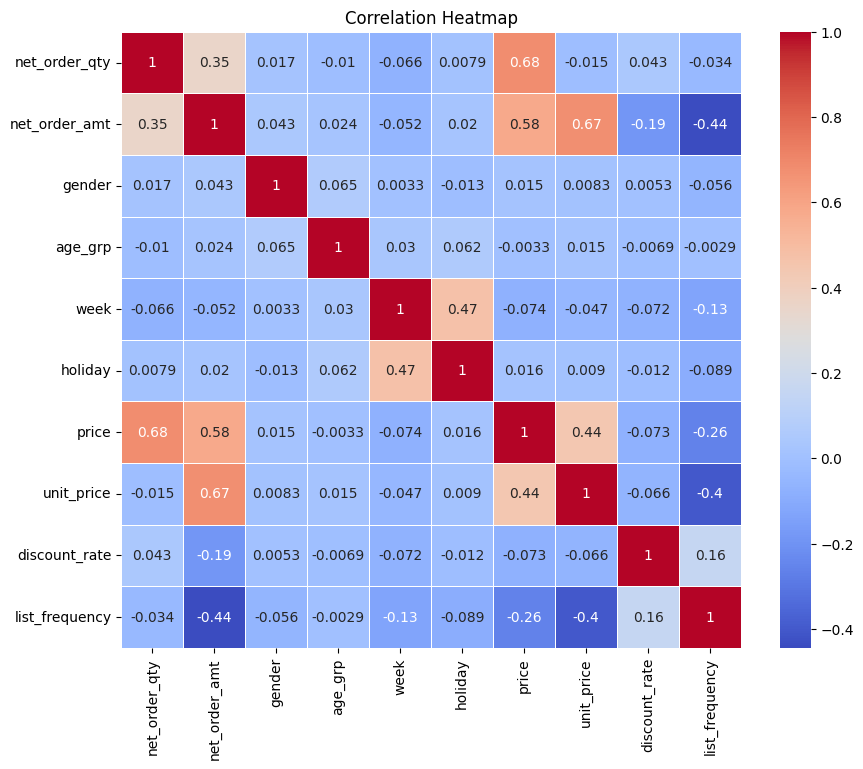

In [127]:

numeric_columns = train_set.select_dtypes(include=['float', 'int'])

corr_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# emp model 학습

In [165]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):

    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(train_set, y_train)
preds = xgb.predict(valid_set)
pred_proba = xgb.predict_proba(valid_set)[:, 1]

get_clf_eval(y_valid, preds, pred_proba)

오차 행렬
[[1866  440]
 [ 422 3216]]
정확도: 0.8550, 정밀도: 0.8796, 재현율: 0.8840, F1: 0.8818, AUC: 0.9392


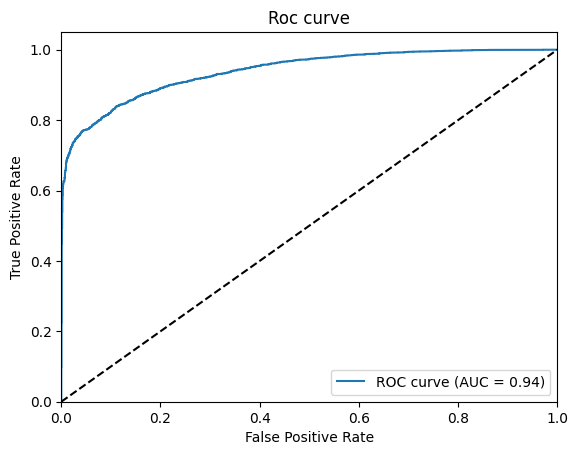

In [129]:

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.legend(loc='lower right')
plt.show()


## fold 적용

### base 모델

In [ ]:
# 주문번호 묶어서 하는 건 구현 못함, kfold가 이미 처리해주기때문에

n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=29)

f1_scores = []

for train_index, val_index in skf.split(train, y_train):
    X_train_fold, X_val_fold = train.iloc[train_index], train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # train
    # 정가변환 
    X_train_fold['price'] = X_train_fold.net_order_amt.apply(lambda x: math.e ** x)
    X_train_fold['qty1_price'] = X_train_fold['price'] / X_train_fold['net_order_qty']
    unit_price = X_train_fold.groupby('product_name')['qty1_price'].max().reset_index().rename(columns={'qty1_price': 'unit_price'})
    X_train_fold = X_train_fold.merge(unit_price, on='product_name', how='left')
    X_train_fold['discount_rate'] = 1 - (X_train_fold['price'] / (X_train_fold['unit_price'] * X_train_fold['net_order_qty']))
    X_train_fold.drop(['qty1_price'], axis=1, inplace=True)
    # 빈도수
    bracket_encoder = CountEncoder(cols="list_in", normalize=True)
    X_train_fold["list_frequency"] = bracket_encoder.fit_transform(X_train_fold["list_in"])
    X_train_fold.drop(['scd', 'product_name', 'list_in'], axis=1, inplace=True)


    # valid
    # 정가변환
    X_val_fold['price'] = X_val_fold.net_order_amt.apply(lambda x: math.e ** x)
    X_val_fold = X_val_fold.merge(unit_price, on='product_name', how='left')
    X_val_fold['discount_rate'] = 1 - (X_val_fold['price'] / (X_val_fold['unit_price'] * X_val_fold['net_order_qty']))
    # 빈도수
    X_val_fold["list_frequency"] = bracket_encoder.transform(X_val_fold["list_in"])
    X_val_fold.drop(['scd', 'product_name', 'list_in'], axis=1, inplace=True)


    model = XGBClassifier()
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)],
                eval_metric="auc", early_stopping_rounds=10, verbose=False)

    y_val_pred = model.predict(X_val_fold)
    f1_scores.append(f1_score(y_val_fold, y_val_pred))


mean_f1_score = np.mean(f1_scores)
print(mean_f1_score)


### 하이퍼 파라미터 튜닝

In [176]:
search_space = {
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'objective': 'binary:logistic',
    'max_depth': hp.choice('max_depth', range(4,16)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'min_child_weight': hp.choice('min_child_weight', range(1, 10)),    
    'reg_alpha': hp.loguniform('reg_alpha', -10, 10),
    'reg_lambda': hp.loguniform('reg_lambda', -10, 10),
    'verbosity': 1,
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.1, 10),
    'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),

}

In [177]:
# 주문번호 묶어서 하는 건 구현 못함, kfold가 이미 처리해주기때문에

n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=29)

def hyperparameter_tuning(space):
    f1_scores = []

    for train_index, val_index in skf.split(train, y_train):
        X_train_fold, X_val_fold = train.iloc[train_index], train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # train
        # 정가변환 
        X_train_fold['price'] = X_train_fold.net_order_amt.apply(lambda x: math.e ** x)
        X_train_fold['qty1_price'] = X_train_fold['price'] / X_train_fold['net_order_qty']
        unit_price = X_train_fold.groupby('product_name')['qty1_price'].max().reset_index().rename(columns={'qty1_price': 'unit_price'})
        X_train_fold = X_train_fold.merge(unit_price, on='product_name', how='left')
        X_train_fold['discount_rate'] = 1 - (X_train_fold['price'] / (X_train_fold['unit_price'] * X_train_fold['net_order_qty']))
        X_train_fold.drop(['qty1_price'], axis=1, inplace=True)
        # 빈도수
        bracket_encoder = CountEncoder(cols="list_in", normalize=True)
        X_train_fold["list_frequency"] = bracket_encoder.fit_transform(X_train_fold["list_in"])
        X_train_fold.drop(['scd', 'product_name', 'list_in'], axis=1, inplace=True)


        # valid
        # 정가변환
        X_val_fold['price'] = X_val_fold.net_order_amt.apply(lambda x: math.e ** x)
        X_val_fold = X_val_fold.merge(unit_price, on='product_name', how='left')
        X_val_fold['discount_rate'] = 1 - (X_val_fold['price'] / (X_val_fold['unit_price'] * X_val_fold['net_order_qty']))
        # 빈도수
        X_val_fold["list_frequency"] = bracket_encoder.transform(X_val_fold["list_in"])
        X_val_fold.drop(['scd', 'product_name', 'list_in'], axis=1, inplace=True)


        model = XGBClassifier(**space)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)],
                  eval_metric="auc", early_stopping_rounds=10, verbose=False)

        y_val_pred = model.predict(X_val_fold)
        f1_scores.append(f1_score(y_val_fold, y_val_pred))



    mean_f1_score = np.mean(f1_scores)
    print(mean_f1_score)

    return {'loss': 1-mean_f1_score, 'status': STATUS_OK}



trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=search_space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials,
            rstate=np.random.default_rng(seed=29))

print(best)


0.858780951897281                                      
0.0                                                                             
[01:05:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[01:05:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[01:05:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[01:05:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[01:05:18] WARNING: /Users/runner/work/xgboost/xgboost/

In [179]:
score = 1 - 0.08281629484270903
print("best f1 score = %0.5f" % score)


best f1 score = 0.91718


In [178]:
best

{'booster': 0,
 'learning_rate': 0.30568863319033185,
 'max_depth': 11,
 'min_child_weight': 0,
 'n_estimators': 84,
 'reg_alpha': 0.0561760641722644,
 'reg_lambda': 0.012132700049299814,
 'scale_pos_weight': 5.552834155959141}

In [183]:
xgb = XGBClassifier(max_depth = best['max_depth'],
                              n_estimators=best['n_estimators'],
                         reg_alpha = best['reg_alpha'],
                        learning_rate = best['learning_rate'], min_child_weight = best['min_child_weight'],
                         reg_lambda = best['reg_lambda'], scale_pos_weight = best['scale_pos_weight'])
    

In [184]:
xgb.fit(train_set, y_train)
preds = xgb.predict(valid_set)
pred_proba = xgb.predict_proba(valid_set)[:, 1]

get_clf_eval(y_valid, preds, pred_proba)

오차 행렬
[[1836  470]
 [ 288 3350]]
정확도: 0.8725, 정밀도: 0.8770, 재현율: 0.9208, F1: 0.8984, AUC: 0.9517


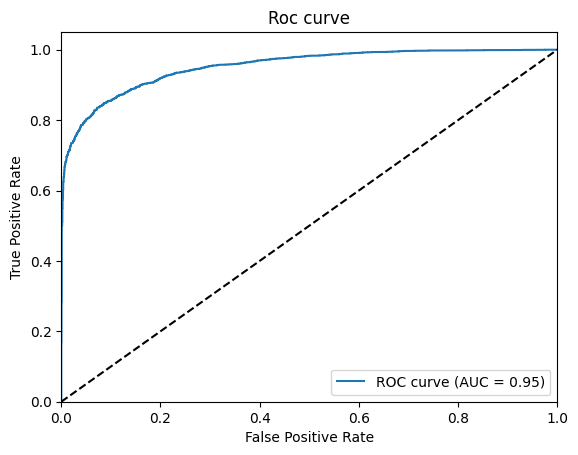

In [185]:

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.legend(loc='lower right')
plt.show()


# 모델 저장

In [186]:
xgb.save_model('./emp_model.model')

# 후처리

In [187]:
# 같은 주문번호인 상품들의 프라임 예측의 평균이 0.5이상이면 모두 프라임으로 예측
pred_df = valid_set.copy()
pred_df['scd'] = valid_scd
pred_df['ori_preds'] = preds
preds = pred_df.groupby('scd')['ori_preds'].mean().agg(round).reset_index().rename(columns={'ori_preds': 'preds'})
pred_df = pred_df.merge(preds, on='scd', how='left')

In [188]:
get_clf_eval(y_valid, pred_df.preds, pred_proba)

오차 행렬
[[2065  241]
 [ 138 3500]]
정확도: 0.9362, 정밀도: 0.9356, 재현율: 0.9621, F1: 0.9486, AUC: 0.9517


In [189]:
pred_df = valid_set.copy()
pred_df['scd'] = valid_scd
pred_df['ori_preds'] = pred_proba
preds = pred_df.groupby('scd')['ori_preds'].mean().reset_index().rename(columns={'ori_preds': 'preds'})
pred_df = pred_df.merge(preds, on='scd', how='left')

In [190]:
grouped_df = pred_df.groupby('scd').apply(lambda x: x.reset_index(drop=True))


In [149]:
grouped_df[['ori_preds', 'preds']].head(10)

ori_preds     preds
scd                                  
20230101963226 0   0.312020  0.310900
               1   0.117598  0.310900
               2   0.803821  0.310900
               3   0.010159  0.310900
20230101963247 0   0.998577  0.960097
               1   0.998342  0.960097
               2   0.851543  0.960097
               3   0.954682  0.960097
               4   0.997341  0.960097
20230101963253 0   0.996210  0.984513

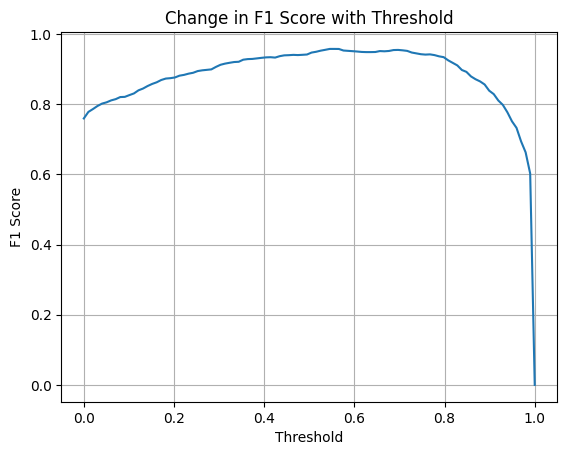

In [191]:
import matplotlib.pyplot as plt


thresholds = np.linspace(0, 1, 100)  # Define a range of threshold values
f1_scores = []  # To store the F1 scores

for threshold in thresholds:
    allocation = np.where(pred_df.preds > threshold, 1, 0)  # Apply thresholding
    f1 = f1_score(y_valid, allocation)  # Calculate the F1 score
    f1_scores.append(f1)

# Plot the F1 scores against the threshold values
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Change in F1 Score with Threshold')
plt.grid(True)
plt.show()


In [192]:
max_f1_score = max(f1_scores)
max_threshold = thresholds[f1_scores.index(max_f1_score)]

print("Highest F1 Score:", max_f1_score)
print("Threshold with Highest F1 Score:", max_threshold)

Highest F1 Score: 0.9574323405412756
Threshold with Highest F1 Score: 0.5454545454545455


# 모델 해석

In [ ]:
# pdp plot 추가 (동하)

# cus model 학습

In [133]:
# train, valid set 분리
cus_group_data = cus_data.groupby(by=['scd']).mean()[['prime_yn']]
X = cus_group_data.index.values.reshape(-1, 1)
y = cus_group_data.prime_yn.values

train_list, valid_list, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=random_state)

train_list = train_list.reshape(-1)
valid_list = valid_list.reshape(-1)

train_set = cus_data.iloc[cus_data[cus_data.scd.isin(train_list)].index, :]
valid_set = cus_data.iloc[cus_data[cus_data.scd.isin(valid_list)].index, :]

y_train = train_set.prime_yn
#train_set = train_set.drop('prime_yn', axis=1)
y_valid = valid_set.prime_yn
#valid_set = valid_set.drop('prime_yn', axis=1)

# 'list_in' 컬럼 빈도수 인코딩
encoder = CountEncoder(cols="list_in", normalize=True)
train_set["list_frequency"] = encoder.fit_transform(train_set["list_in"])
valid_set["list_frequency"] = encoder.transform(valid_set["list_in"])

train_set.drop(['scd', 'list_in'], axis=1, inplace=True)
valid_scd = valid_set.scd
valid_set.drop(['scd', 'list_in'], axis=1, inplace=True)

train_set

,product_name,net_order_qty,net_order_amt,gender,age_grp,prime_yn,건강식품,국/김치/김/반찬/두부,대용량 식자재,돈까스/함박/구이,...,밀키트,밥/죽/면,스팸/닭가슴살/소시지,신선식품,양념/소스/가루/오일,음료/생수/시럽,핫도그/떡볶이/간식,week,holiday,list_frequency
0,비비고X호족반 NY 양념갈비만두 384g*2번들,3,10.234373,0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.616532
1,그대로 끓여먹는 바지락꽃게 된장찌개 양념 450gX2개,1,9.190036,1,2,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0.616532
2,핫케익믹스1kg,1,7.955776,0,3,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0.616532
3,크레잇 치킨가라아게 1kg,1,8.998384,0,3,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0.616532
4,밀당의고수 바삭한 김말이 400g,1,7.992945,0,3,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0.616532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26065,비비고 왕교자 1.05kgX2개,2,10.319134,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,6,1,0.616532
26066,오곡참깨 드레싱105g,2,8.232440,0,3,0,0,0,0,0,...,0,0,0,0,1,0,0,6,1,0.616532
26067,밀당의고수 바삭한 김말이 400g,1,8.609043,0,3,0,0,0,0,0,...,0,0,0,0,0,0,1,6,1,0.616532
26068,고메 바삭튀겨낸모짜렐라돈카츠450gX2개,1,9.534885,0,3,0,0,0,0,1,...,0,0,0,0,0,0,0,6,1,0.616532


In [118]:
train_set.drop(["product_name"], axis=1,inplace=True)

In [120]:
valid_set.drop(["product_name"], axis=1,inplace=True)

In [10]:
def get_clf_eval(y_test, pred=None, pred_proba=None):

    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(train_set, y_train)
preds = xgb.predict(valid_set)
pred_proba = xgb.predict_proba(valid_set)[:, 1]

get_clf_eval(y_valid, preds, pred_proba)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:product_name

# 후처리

In [46]:
# 같은 주문번호인 상품들의 프라임 예측의 평균이 0.5이상이면 모두 프라임으로 예측
pred_df = valid_set.copy()
pred_df['scd'] = valid_scd
pred_df['ori_preds'] = preds
preds = pred_df.groupby('scd')['ori_preds'].mean().agg(round).reset_index().rename(columns={'ori_preds': 'preds'})
pred_df = pred_df.merge(preds, on='scd', how='left')

In [47]:
get_clf_eval(y_valid, pred_df.preds, pred_proba)

오차 행렬
[[3857  150]
 [ 322 3304]]
정확도: 0.9382, 정밀도: 0.9566, 재현율: 0.9112, F1: 0.9333, AUC: 0.9740


# 모델 저장

In [48]:
xgb.save_model('./cus_model.model')

In [49]:
new_xgb = XGBClassifier()
new_xgb.load_model('./cus_model.model')
preds = new_xgb.predict(valid_set)
pred_proba = new_xgb.predict_proba(valid_set)[:, 1]

get_clf_eval(y_valid, preds, pred_proba)

오차 행렬
[[3785  222]
 [ 423 3203]]
정확도: 0.9155, 정밀도: 0.9352, 재현율: 0.8833, F1: 0.9085, AUC: 0.9740


# PDP

In [29]:
import pandas as pd
from xgboost import XGBClassifier

In [30]:
from pdpbox import info_plots
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

## emp

In [96]:
train_set["prime_yn"] = y_train.values

In [98]:
train_set.dropna(inplace=True)
valid_set.dropna(inplace=True)

In [99]:
y_train = train_set["prime_yn"]

In [100]:
train_set

,net_order_qty,net_order_amt,gender,age_grp,prime_yn,건강식품,국/김치/김/반찬/두부,대용량 식자재,돈까스/함박/구이,만두/피자/치킨,...,신선식품,양념/소스/가루/오일,음료/생수/시럽,핫도그/떡볶이/간식,week,holiday,price,unit_price,discount_rate,list_frequency
0,1,8.883224,0,3,1,0,1,0,0,0,...,0,0,0,0,1,0,7210.0,7604.00,0.051815,0.091624
1,1,10.351341,0,3,1,0,0,0,0,0,...,0,0,0,0,1,0,31299.0,32709.00,0.043107,0.091624
2,2,10.845621,0,2,1,0,0,0,0,0,...,0,0,1,0,1,0,51309.0,26911.00,0.046691,0.689705
3,1,10.248105,0,3,1,0,0,0,0,0,...,0,0,1,0,1,0,28229.0,29610.50,0.046656,0.689705
4,1,9.003808,1,1,1,0,0,0,1,0,...,0,0,0,0,1,0,8134.0,8533.00,0.046760,0.689705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13856,1,8.769663,1,4,1,0,0,0,0,0,...,0,0,1,0,6,1,6436.0,6751.00,0.046660,0.689705
13857,1,8.184235,1,4,1,0,0,0,0,0,...,0,0,0,1,6,1,3584.0,3645.75,0.016938,0.143929
13858,1,9.713356,1,4,1,0,0,0,0,0,...,0,0,0,0,6,1,16537.0,17137.00,0.035012,0.143929
13859,1,8.689128,1,4,1,0,0,0,0,0,...,0,0,0,0,6,1,5938.0,6183.00,0.039625,0.143929


In [101]:
X = train_set.drop("prime_yn", axis=1)

In [102]:
y_train

0        1
1        1
2        1
3        1
4        1
        ..
13856    1
13857    1
13858    1
13859    1
13860    1
Name: prime_yn, Length: 13861, dtype: int64

In [103]:
model = XGBClassifier()
model.fit(X, y_train)

[00:23:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [104]:
abs(train_set.corr()["prime_yn"]).sort_values(ascending=False)[:5]

prime_yn         1.000000
discount_rate    0.200862
age_grp          0.128700
gender           0.060522
국/김치/김/반찬/두부     0.034864
Name: prime_yn, dtype: float64

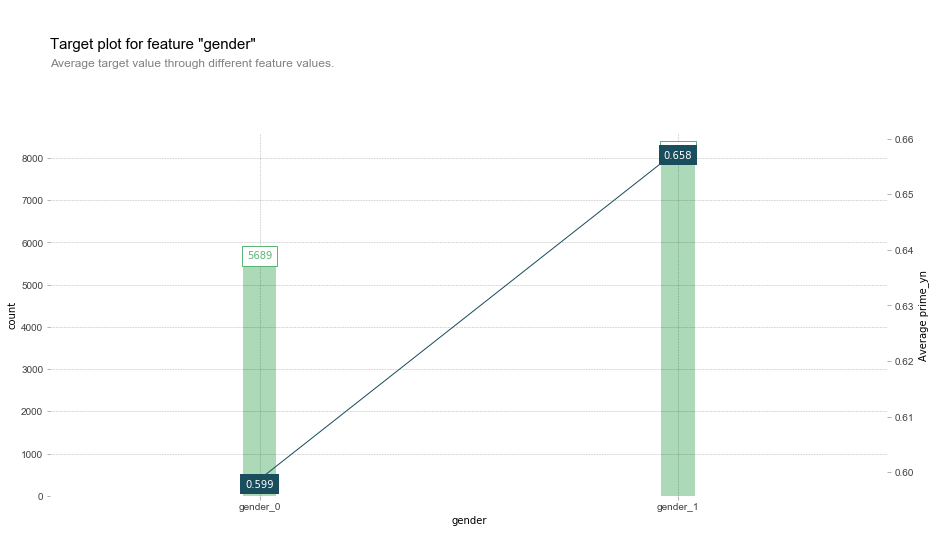

In [105]:
fig, axes, summary_df = info_plots.target_plot(
    df=train_set,
    feature="gender",
    feature_name="gender",
    target="prime_yn"
)

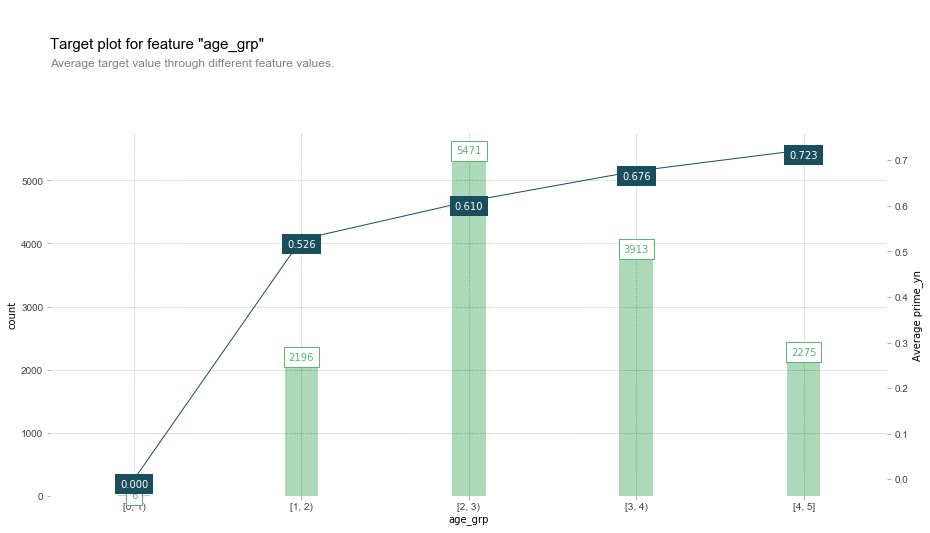

In [106]:
fig, axes, summary_df = info_plots.target_plot(
    df=train_set,
    feature="age_grp",
    feature_name="age_grp",
    target="prime_yn"
)

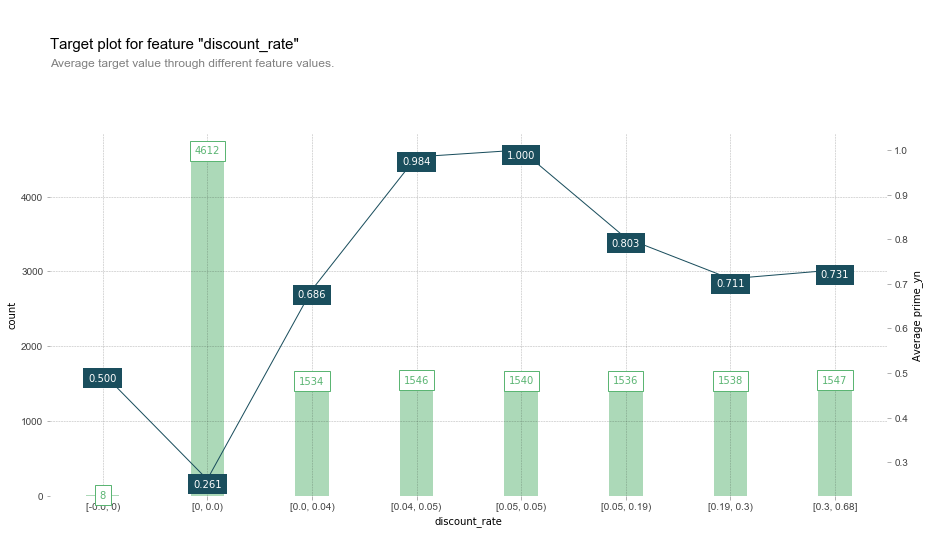

In [107]:
fig, axes, summary_df = info_plots.target_plot(
    df=train_set,
    feature="discount_rate",
    feature_name="discount_rate",
    target="prime_yn"
)

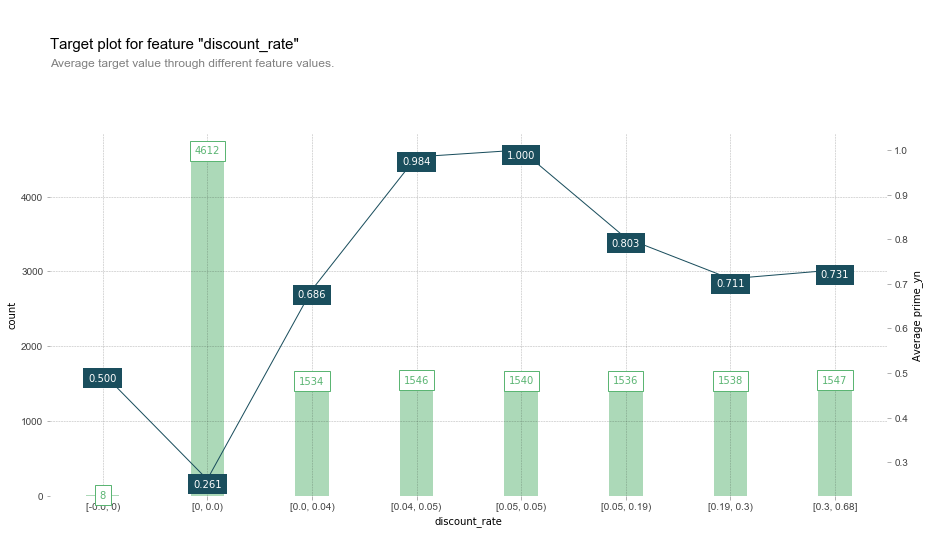

In [108]:
fig, axes, summary_df = info_plots.target_plot(
    df=train_set,
    feature="discount_rate",
    feature_name="discount_rate",
    target="prime_yn"
)

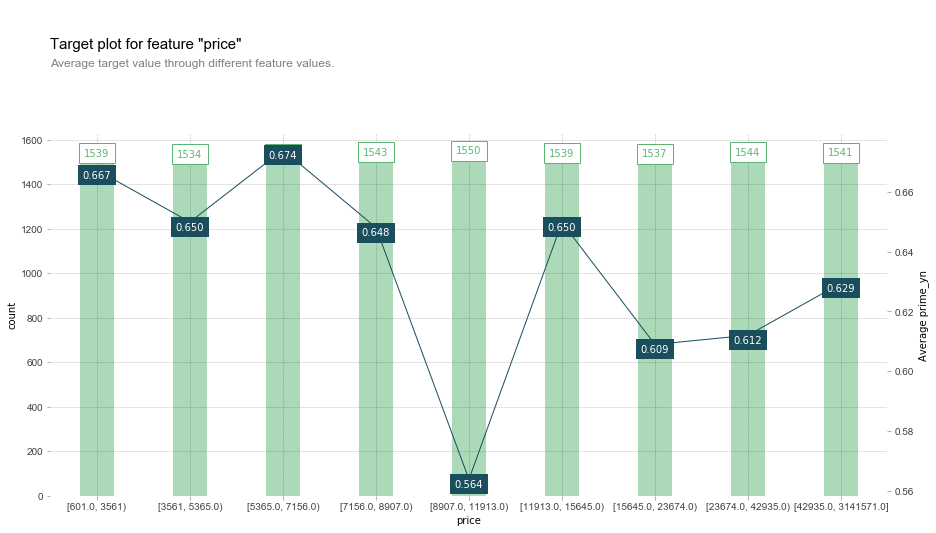

In [109]:
fig, axes, summary_df = info_plots.target_plot(
    df=train_set,
    feature="price",
    feature_name="price",
    target="prime_yn"
)

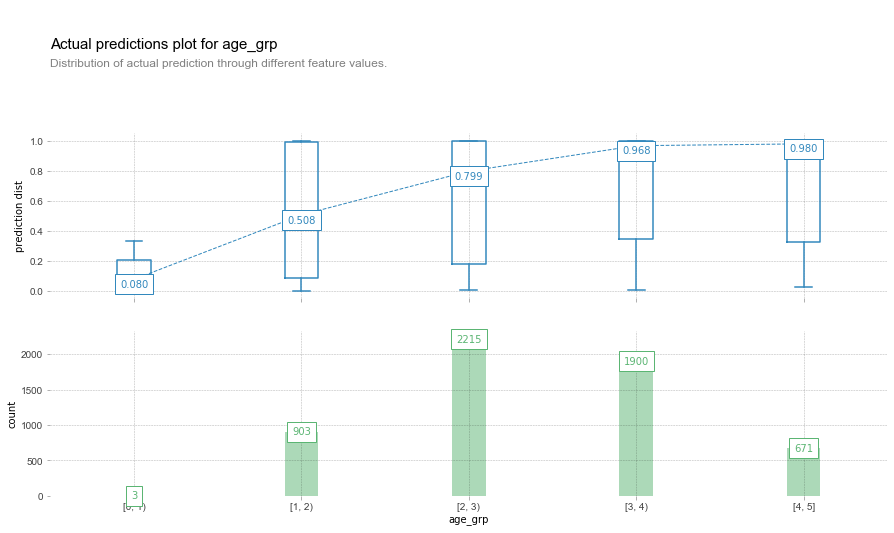

In [110]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model,
    X=valid_set.drop("prime_yn", axis=1),
    feature="age_grp",
    feature_name="age_grp",
    predict_kwds={}
)

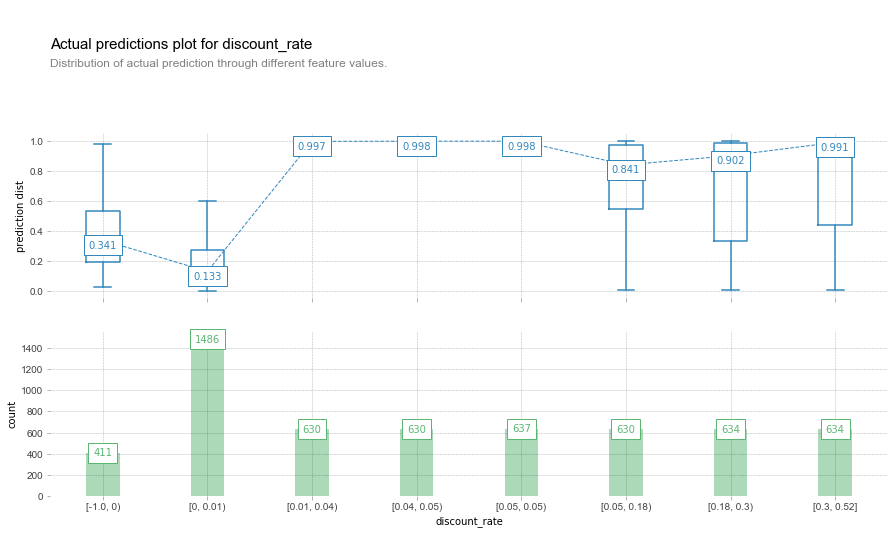

In [112]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model,
    X=valid_set.drop("prime_yn", axis=1),
    #X=train_set.drop("prime_yn", axis=1),
    feature="discount_rate",
    feature_name="discount_rate",
    predict_kwds={}
)

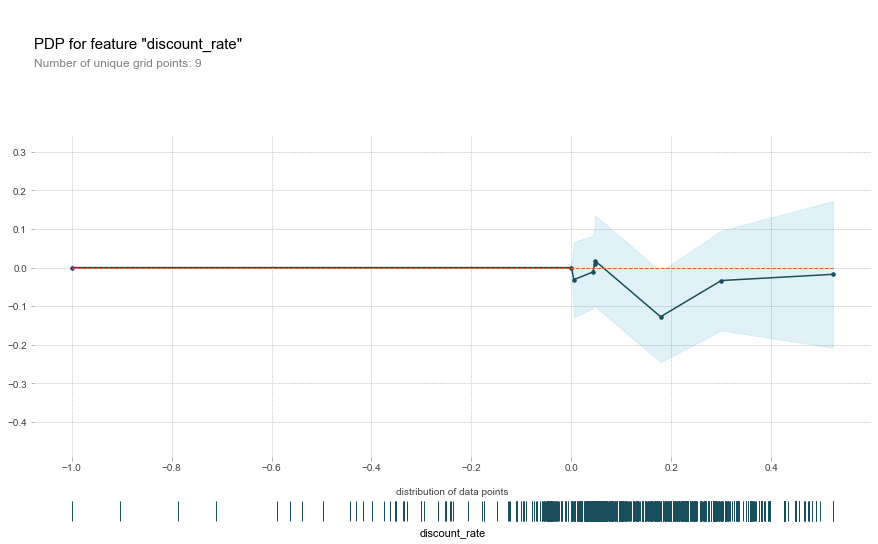

In [71]:
pdp_gc = pdp_isolate(
    model=model,
    dataset=valid_set,
    model_features=X.columns,
    feature="discount_rate"
)

fig, axes = pdp_plot(
    pdp_gc,
    "discount_rate",
    plot_lines=False,
    frac_to_plot=0.5,
    plot_pts_dist=True
)

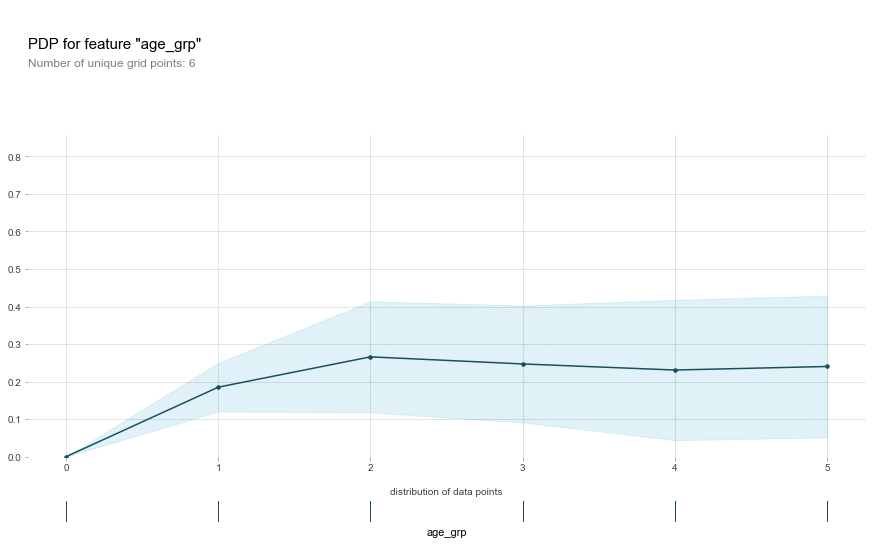

In [72]:
pdp_gc = pdp_isolate(
    model=model,
    dataset=valid_set,
    model_features=X.columns,
    feature="age_grp"
)

fig, axes = pdp_plot(
    pdp_gc,
    "age_grp",
    plot_lines=False,
    frac_to_plot=0.5,
    plot_pts_dist=True
)

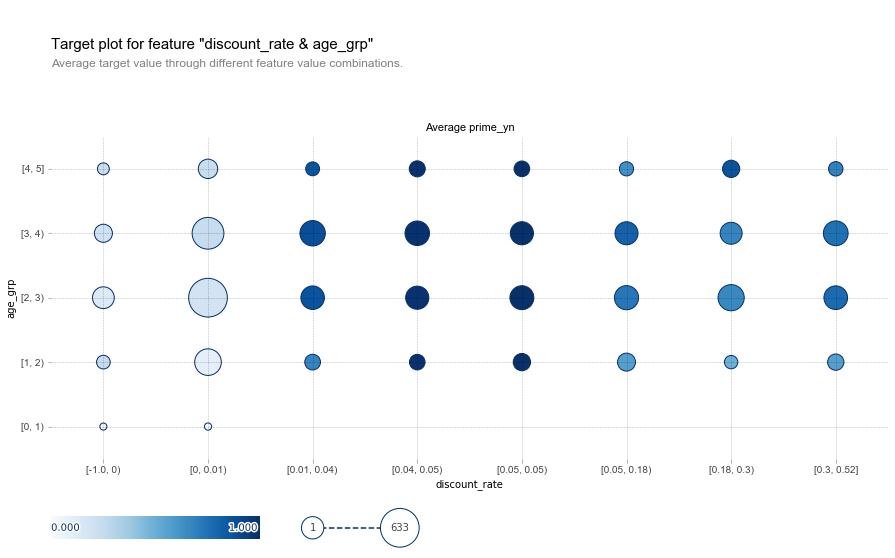

In [73]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=valid_set,
    features=["discount_rate", "age_grp"],
    feature_names=["discount_rate", "age_grp"],
    target="prime_yn"
)

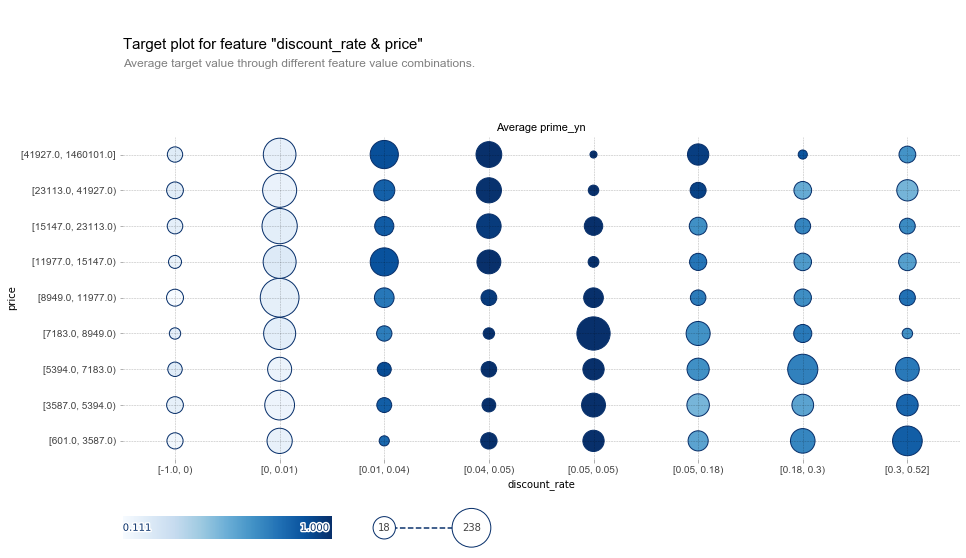

In [74]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=valid_set,
    features=["discount_rate", "price"],
    feature_names=["discount_rate", "price"],
    target="prime_yn"
)

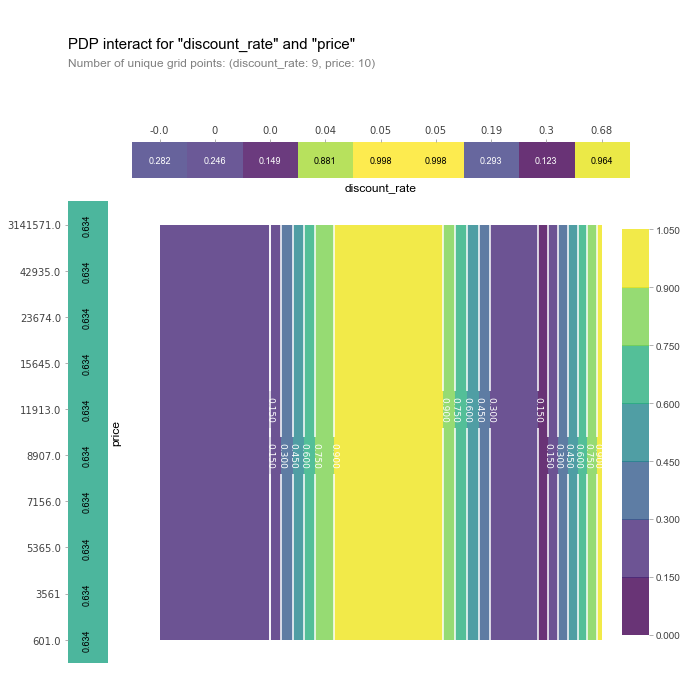

In [68]:
pdp_interaction = pdp_interact(
    model=model,
    dataset=train_set,
    model_features=X.columns,
    features=["discount_rate", "price"]
)

fig, axes = pdp_interact_plot(
    pdp_interact_out=pdp_interaction,
    feature_names=["discount_rate", "price"],
    plot_type="contour",
    x_quantile=True,
    plot_pdp=True
)

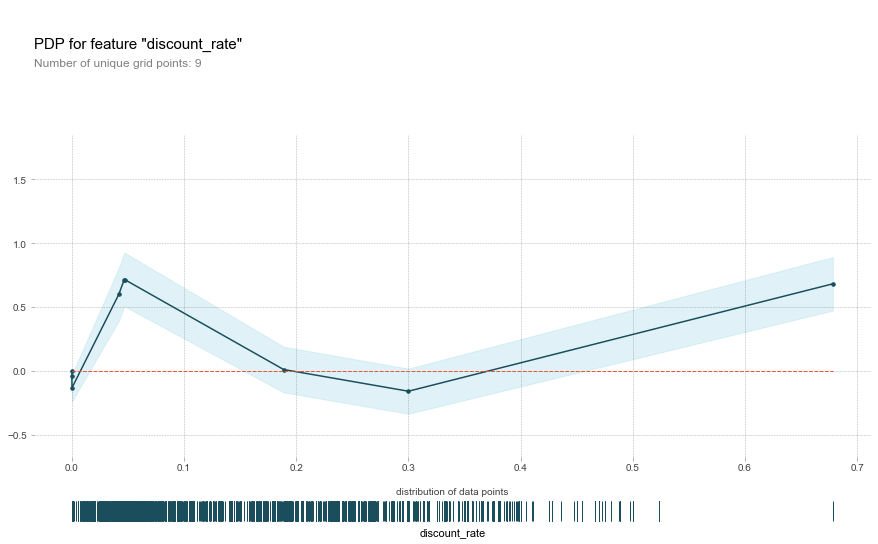

In [70]:
pdp_bp = pdp_isolate(
    model=model,
    dataset=train_set,
    model_features=X.columns,
    feature="discount_rate"
)

fig, axes = pdp_plot(pdp_bp,
                         "discount_rate",
                         plot_lines=False,
                         frac_to_plot=0.5,
                         plot_pts_dist=True
)

In [72]:
import shap

idx = 10

print(X.iloc[idx, :])

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.force_plot(explainer.expected_value,
                shap_values[idx, :],
                X.iloc[idx, :])

net_order_qty         1.000000
net_order_amt         9.750395
gender                1.000000
age_grp               2.000000
건강식품                  0.000000
국/김치/김/반찬/두부          0.000000
대용량 식자재               0.000000
돈까스/함박/구이             0.000000
만두/피자/치킨              0.000000
밀키트                   0.000000
밥/죽/면                 0.000000
스팸/닭가슴살/소시지           0.000000
신선식품                  0.000000
양념/소스/가루/오일           1.000000
음료/생수/시럽              0.000000
핫도그/떡볶이/간식            0.000000
week                  1.000000
holiday               0.000000
price             17161.000000
unit_price        17161.000000
discount_rate         0.000000
list_frequency        0.689705
Name: 10, dtype: float64


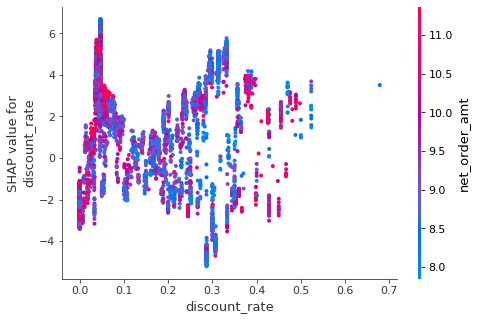

In [73]:
shap.dependence_plot("discount_rate", shap_values, X)

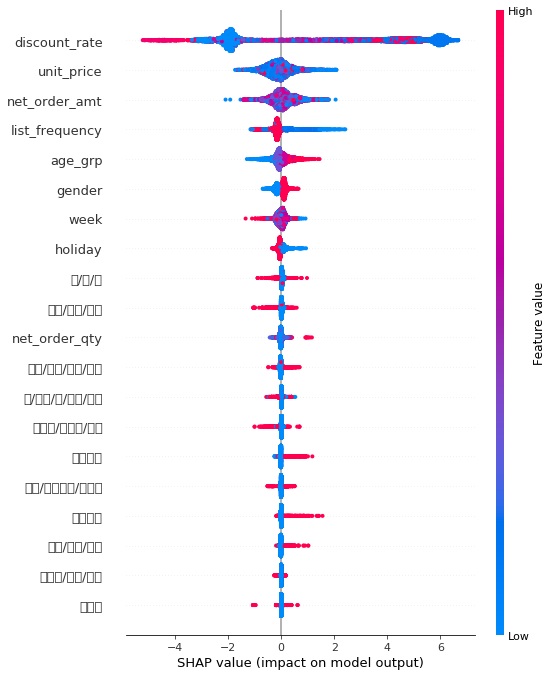

In [74]:
shap.summary_plot(shap_values, X)

# cus

In [147]:
train_set["prime_yn"] = y_train.values

In [148]:
train_set.dropna(inplace=True)
valid_set.dropna(inplace=True)

In [149]:
y_train = train_set["prime_yn"]

In [150]:
train_set

,net_order_qty,net_order_amt,gender,age_grp,prime_yn,건강식품,국/김치/김/반찬/두부,대용량 식자재,돈까스/함박/구이,만두/피자/치킨,...,신선식품,양념/소스/가루/오일,음료/생수/시럽,핫도그/떡볶이/간식,week,holiday,price,unit_price,discount_rate,list_frequency
0,3,10.234373,0,3,1,0,0,0,0,1,...,0,0,0,0,1,0,27844.0,9981.0,0.070100,0.616532
1,1,9.190036,1,2,1,0,1,0,0,0,...,0,0,0,0,1,0,9799.0,9799.0,0.000000,0.616532
2,1,7.955776,0,3,0,0,0,0,0,0,...,0,1,0,0,1,0,2852.0,5281.0,0.459951,0.616532
3,1,8.998384,0,3,0,0,0,1,0,0,...,0,0,0,0,1,0,8090.0,14981.0,0.459983,0.616532
4,1,7.992945,0,3,0,0,0,0,0,0,...,0,0,0,1,1,0,2960.0,5481.0,0.459953,0.616532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18432,2,10.319134,0,3,0,0,0,0,0,1,...,0,0,0,0,6,1,30307.0,15833.0,0.042917,0.616532
18433,2,8.232440,0,3,0,0,0,0,0,0,...,0,1,0,0,6,1,3761.0,1880.5,0.000000,0.616532
18434,1,8.609043,0,3,0,0,0,0,0,0,...,0,0,0,1,6,1,5481.0,5481.0,0.000000,0.616532
18435,1,9.534885,0,3,0,0,0,0,1,0,...,0,0,0,0,6,1,13834.0,16769.0,0.175025,0.616532


In [151]:
X = train_set.drop("prime_yn", axis=1)

In [152]:
y_train

0        1
1        1
2        0
3        0
4        0
        ..
18432    0
18433    0
18434    0
18435    0
18436    0
Name: prime_yn, Length: 18437, dtype: int64

In [153]:
model = XGBClassifier()
model.fit(X, y_train)

[00:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [154]:
abs(train_set.corr()["prime_yn"]).sort_values(ascending=False)[:5]

prime_yn         1.000000
discount_rate    0.203258
age_grp          0.122925
gender           0.108247
net_order_amt    0.093372
Name: prime_yn, dtype: float64

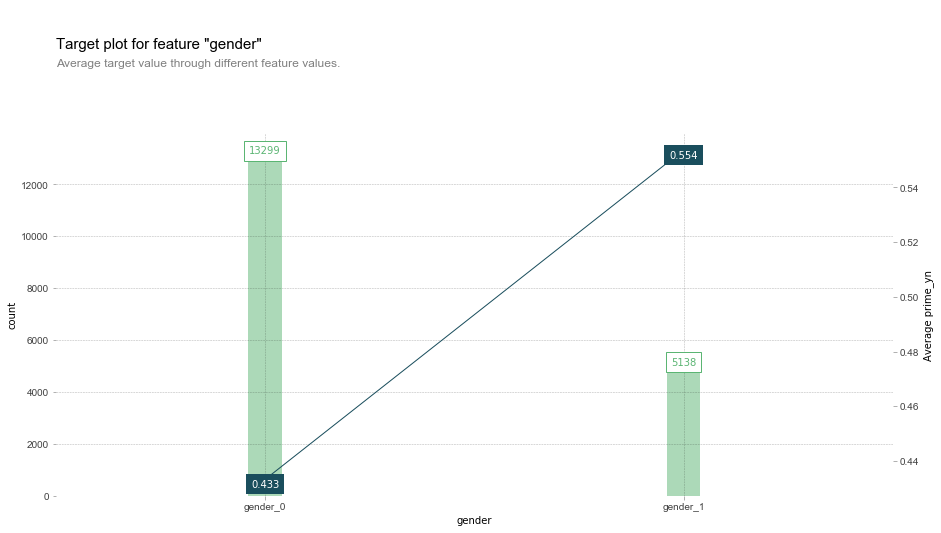

In [155]:
fig, axes, summary_df = info_plots.target_plot(
    df=train_set,
    feature="gender",
    feature_name="gender",
    target="prime_yn"
)

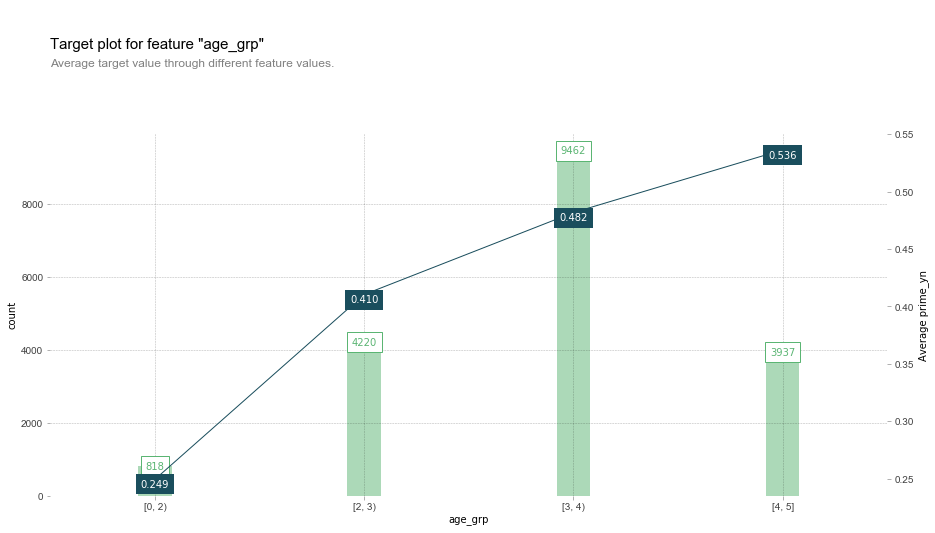

In [156]:
fig, axes, summary_df = info_plots.target_plot(
    df=train_set,
    feature="age_grp",
    feature_name="age_grp",
    target="prime_yn"
)

In [157]:
train_set

,net_order_qty,net_order_amt,gender,age_grp,prime_yn,건강식품,국/김치/김/반찬/두부,대용량 식자재,돈까스/함박/구이,만두/피자/치킨,...,신선식품,양념/소스/가루/오일,음료/생수/시럽,핫도그/떡볶이/간식,week,holiday,price,unit_price,discount_rate,list_frequency
0,3,10.234373,0,3,1,0,0,0,0,1,...,0,0,0,0,1,0,27844.0,9981.0,0.070100,0.616532
1,1,9.190036,1,2,1,0,1,0,0,0,...,0,0,0,0,1,0,9799.0,9799.0,0.000000,0.616532
2,1,7.955776,0,3,0,0,0,0,0,0,...,0,1,0,0,1,0,2852.0,5281.0,0.459951,0.616532
3,1,8.998384,0,3,0,0,0,1,0,0,...,0,0,0,0,1,0,8090.0,14981.0,0.459983,0.616532
4,1,7.992945,0,3,0,0,0,0,0,0,...,0,0,0,1,1,0,2960.0,5481.0,0.459953,0.616532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18432,2,10.319134,0,3,0,0,0,0,0,1,...,0,0,0,0,6,1,30307.0,15833.0,0.042917,0.616532
18433,2,8.232440,0,3,0,0,0,0,0,0,...,0,1,0,0,6,1,3761.0,1880.5,0.000000,0.616532
18434,1,8.609043,0,3,0,0,0,0,0,0,...,0,0,0,1,6,1,5481.0,5481.0,0.000000,0.616532
18435,1,9.534885,0,3,0,0,0,0,1,0,...,0,0,0,0,6,1,13834.0,16769.0,0.175025,0.616532


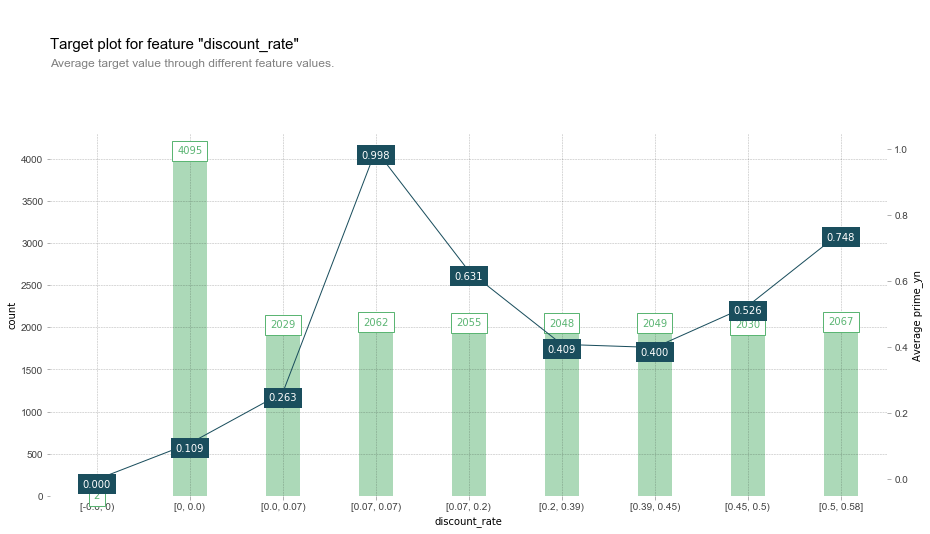

In [158]:
fig, axes, summary_df = info_plots.target_plot(
    df=train_set,
    feature="discount_rate",
    feature_name="discount_rate",
    target="prime_yn"
)

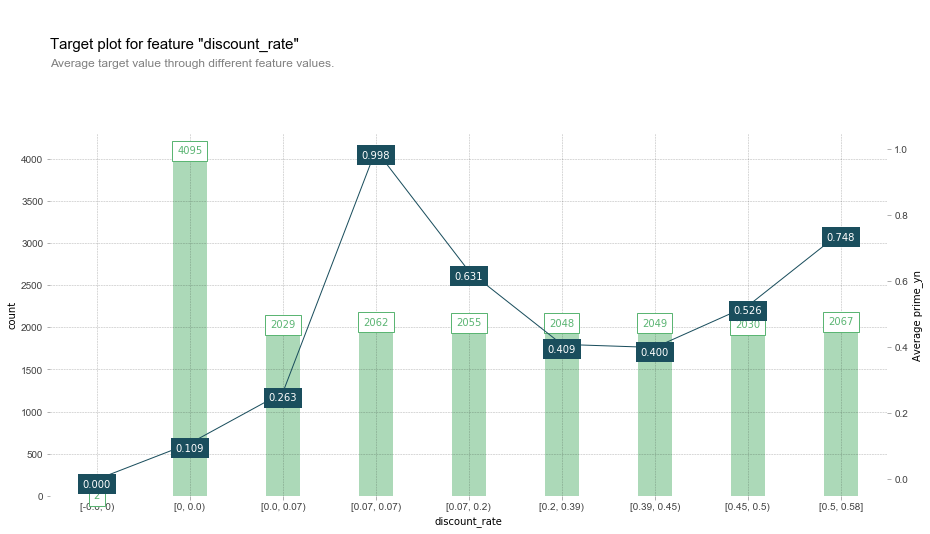

In [159]:
fig, axes, summary_df = info_plots.target_plot(
    df=train_set,
    feature="discount_rate",
    feature_name="discount_rate",
    target="prime_yn"
)

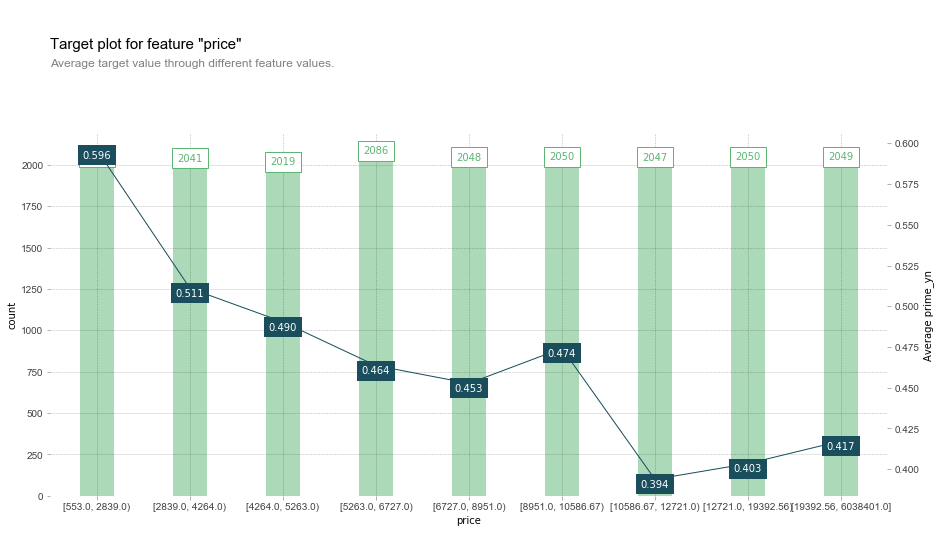

In [160]:
fig, axes, summary_df = info_plots.target_plot(
    df=train_set,
    feature="price",
    feature_name="price",
    target="prime_yn"
)

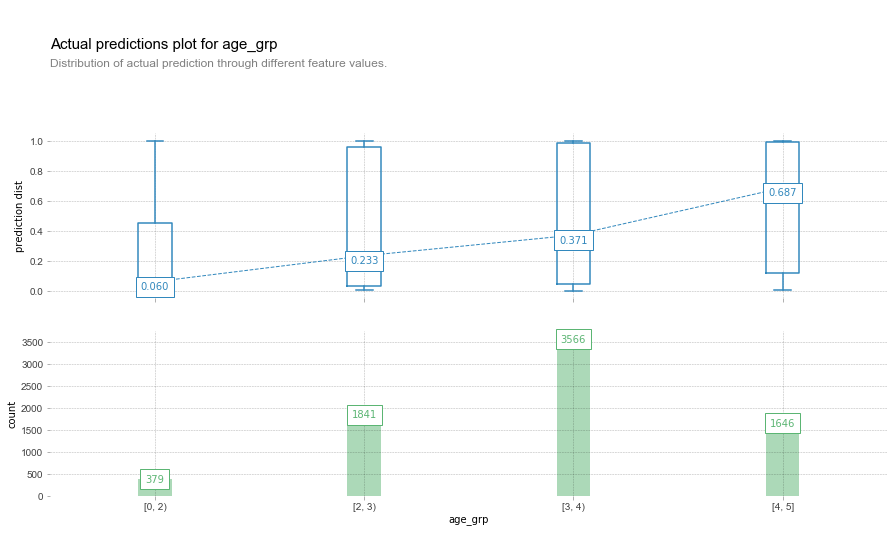

In [161]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model,
    X=valid_set.drop("prime_yn", axis=1),
    feature="age_grp",
    feature_name="age_grp",
    predict_kwds={}
)

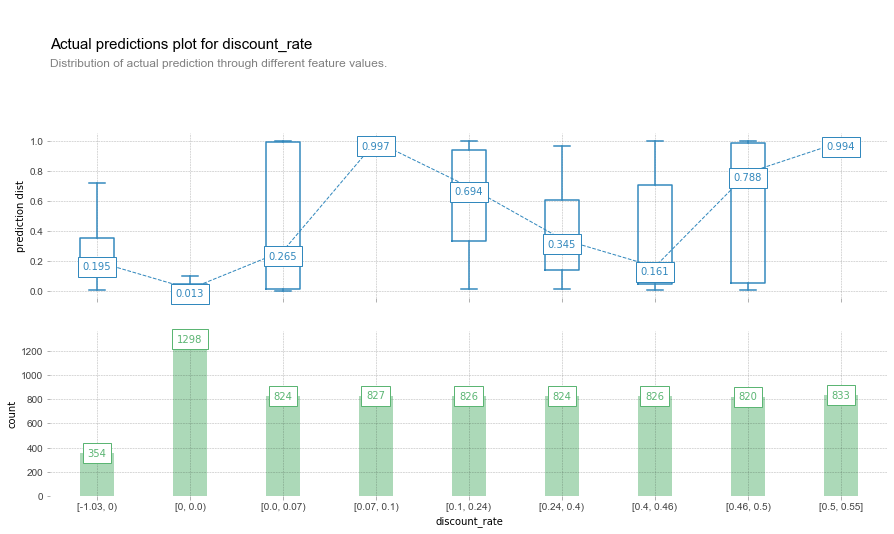

In [162]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model,
    X=valid_set.drop("prime_yn", axis=1),
    #X=train_set.drop("prime_yn", axis=1),
    feature="discount_rate",
    feature_name="discount_rate",
    predict_kwds={}
)

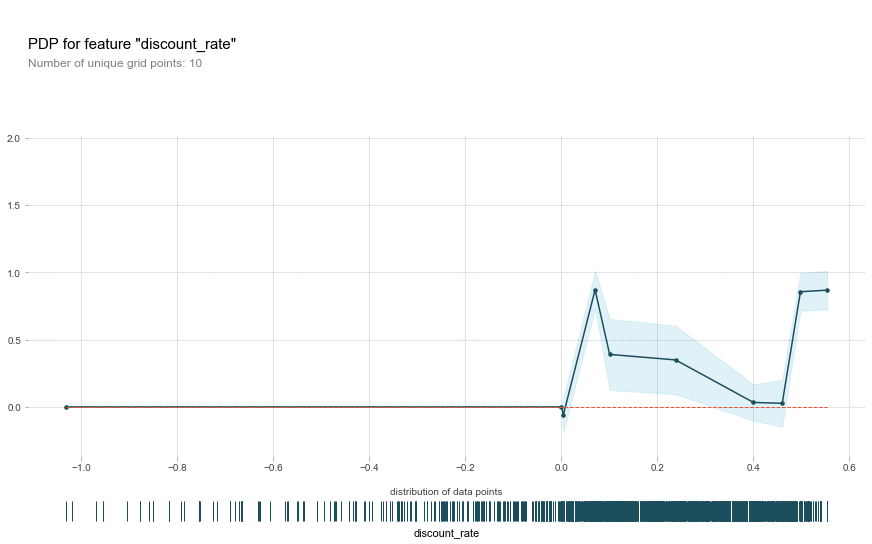

In [163]:
pdp_gc = pdp_isolate(
    model=model,
    dataset=valid_set,
    model_features=X.columns,
    feature="discount_rate"
)

fig, axes = pdp_plot(
    pdp_gc,
    "discount_rate",
    plot_lines=False,
    frac_to_plot=0.5,
    plot_pts_dist=True
)

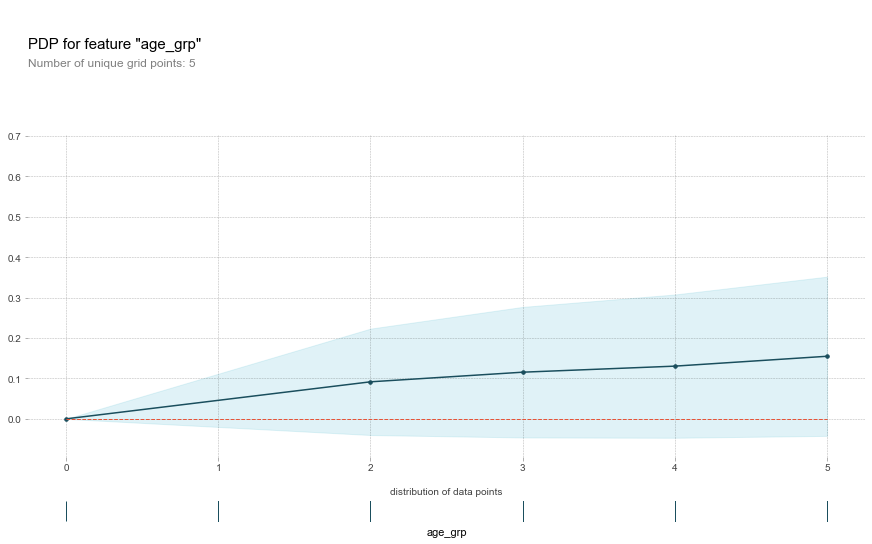

In [164]:
pdp_gc = pdp_isolate(
    model=model,
    dataset=valid_set,
    model_features=X.columns,
    feature="age_grp"
)

fig, axes = pdp_plot(
    pdp_gc,
    "age_grp",
    plot_lines=False,
    frac_to_plot=0.5,
    plot_pts_dist=True
)

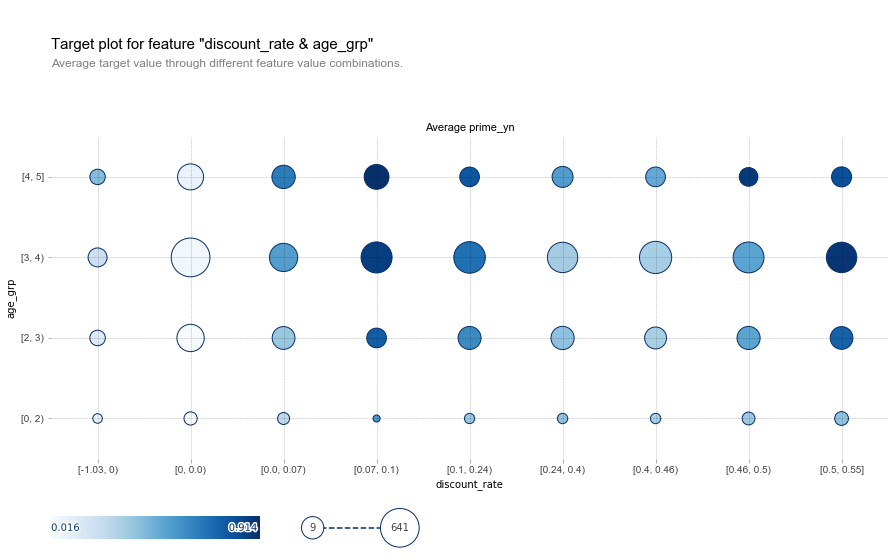

In [165]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=valid_set,
    features=["discount_rate", "age_grp"],
    feature_names=["discount_rate", "age_grp"],
    target="prime_yn"
)

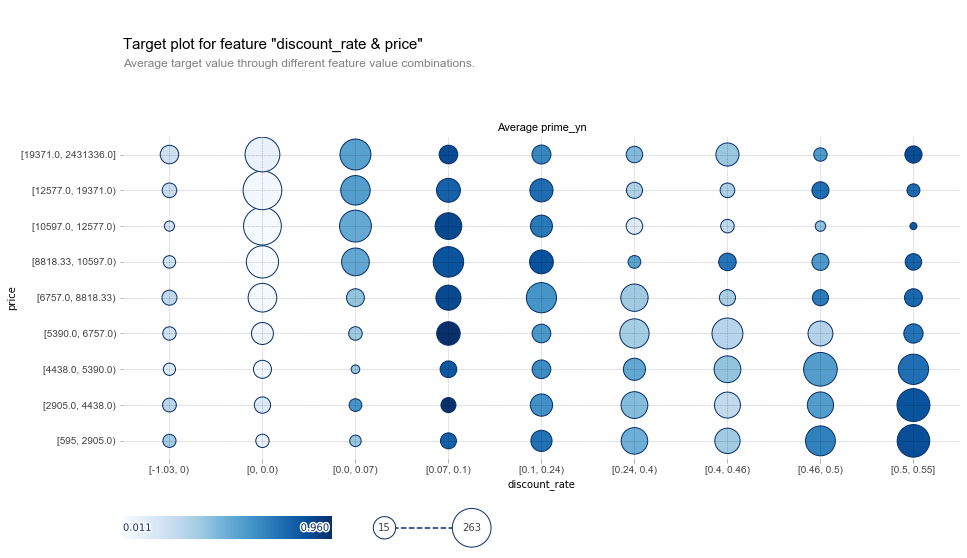

In [166]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=valid_set,
    features=["discount_rate", "price"],
    feature_names=["discount_rate", "price"],
    target="prime_yn"
)

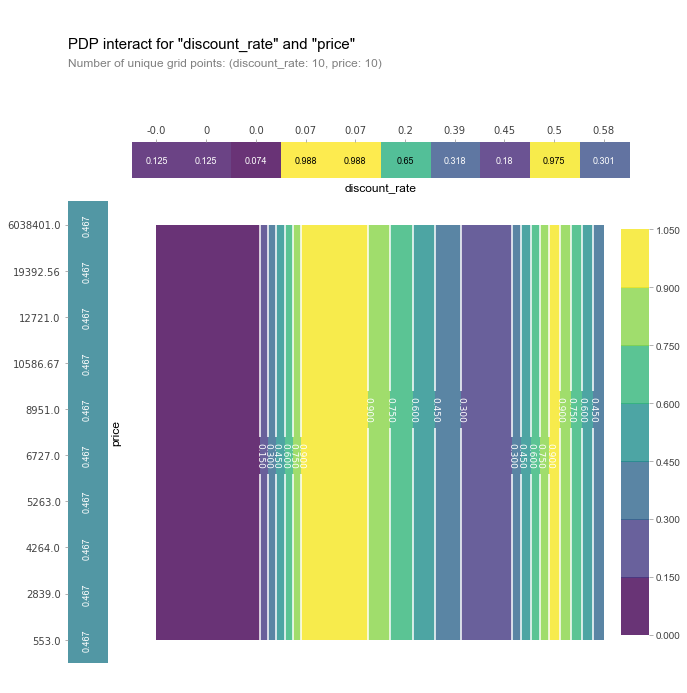

In [167]:
pdp_interaction = pdp_interact(
    model=model,
    dataset=train_set,
    model_features=X.columns,
    features=["discount_rate", "price"]
)

fig, axes = pdp_interact_plot(
    pdp_interact_out=pdp_interaction,
    feature_names=["discount_rate", "price"],
    plot_type="contour",
    x_quantile=True,
    plot_pdp=True
)

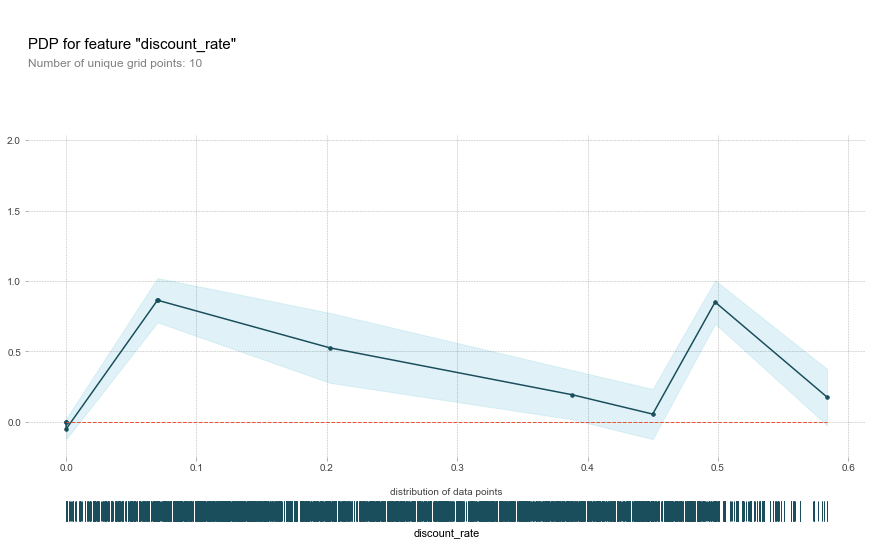

In [168]:
pdp_bp = pdp_isolate(
    model=model,
    dataset=train_set,
    model_features=X.columns,
    feature="discount_rate"
)

fig, axes = pdp_plot(pdp_bp,
                         "discount_rate",
                         plot_lines=False,
                         frac_to_plot=0.5,
                         plot_pts_dist=True
)

In [169]:
import shap

idx = 10

print(X.iloc[idx, :])

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.force_plot(explainer.expected_value,
                shap_values[idx, :],
                X.iloc[idx, :])

net_order_qty        1.000000
net_order_amt        8.486734
gender               0.000000
age_grp              3.000000
건강식품                 0.000000
국/김치/김/반찬/두부         0.000000
대용량 식자재              0.000000
돈까스/함박/구이            0.000000
만두/피자/치킨             0.000000
밀키트                  0.000000
밥/죽/면                1.000000
스팸/닭가슴살/소시지          0.000000
신선식품                 0.000000
양념/소스/가루/오일          0.000000
음료/생수/시럽             0.000000
핫도그/떡볶이/간식           0.000000
week                 1.000000
holiday              0.000000
price             4850.000000
unit_price        8352.000000
discount_rate        0.419301
list_frequency       0.616532
Name: 10, dtype: float64


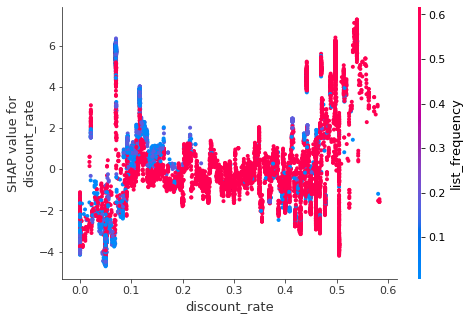

In [170]:
shap.dependence_plot("discount_rate", shap_values, X)

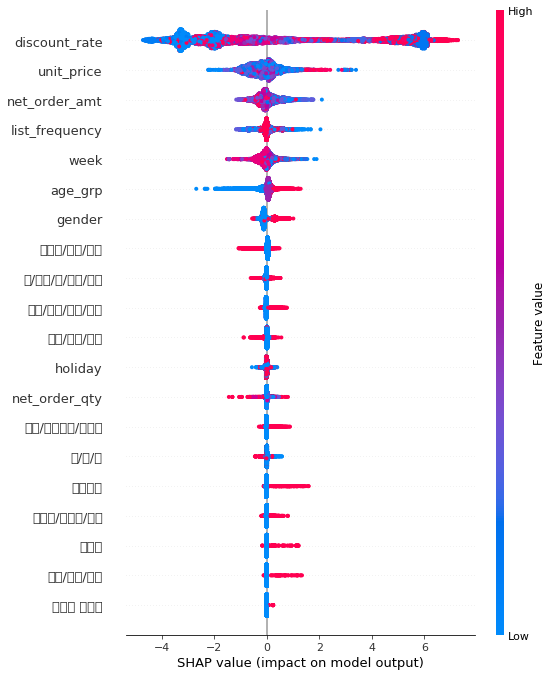

In [171]:
shap.summary_plot(shap_values, X)

# cus

In [172]:
train_set["prime_yn"] = y_train.values

In [173]:
train_set.dropna(inplace=True)
valid_set.dropna(inplace=True)